<a href="https://colab.research.google.com/github/AdamW1002/Fall21Research/blob/main/analysis_of_actvations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
import torch #imports
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

In [ ]:
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
batch_size = 128
n_iters = 3000
num_epochs = 1
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [ ]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
  print("on gpu")
else:  
  dev = "cpu"
class LoggerLayer(nn.Module):
      def __init__(self, other_layer : nn.Module, log : list):
        super(LoggerLayer, self).__init__()
        self.log = log 
        self.layer = other_layer
        self.logging = False#no logging during training

      def forward(self, x):
        y =   self.layer(x)

        if self.logging:  
          self.log.append(y)
        return y
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()


       
        # Linear function
        self.fc1 = nn.Linear(input_dim, 128) 
        #self.fc2 = nn.Linear(128, 32) 
        # Non-linearity
        self.relu = nn.ReLU()

        #loggers
        self.log_relu = nn.ReLU()
        self.logger1 = LoggerLayer(self.log_relu,[])

        # Linear function (readout)
        self.fc3 = nn.Linear(128, output_dim)  

    def forward(self, x):
        
        out = self.fc1(x)

        
        out = self.logger1(out)
        #out = self.fc2(out)
        #out = self.relu(out)

        
        out = self.fc3(out)
        return out

on gpu


In [ ]:
input_dim = 28*28
hidden_dim = 128
output_dim = 10

model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)
print(model.logger1.log)

[]


In [ ]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

In [ ]:
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        # Load images with gradient accumulation capabilities
        images = images.view(-1, 28*28).requires_grad_()

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 100 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            
            for images, labels in test_loader:
                # Load images with gradient accumulation capabilities
                images = images.view(-1, 28*28).requires_grad_()

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                #print(predicted)
                
                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                correct += (predicted == labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
            #print(model.logger1.log[0].shape)

Iteration: 100. Loss: 0.6417722702026367. Accuracy: 86.83999633789062
Iteration: 200. Loss: 0.33663761615753174. Accuracy: 89.3499984741211
Iteration: 300. Loss: 0.36147546768188477. Accuracy: 90.3499984741211
Iteration: 400. Loss: 0.2420046031475067. Accuracy: 90.81999969482422


In [ ]:
data_points = []
model.logger1.logging = True
count = 0
with torch.no_grad():
  for i, (images, labels) in enumerate(train_loader): #look at image and labels
   for image, label in zip(images, labels): 
    
     outputs = model(torch.flatten(image))
     #print("_______")
     #print(torch.max(outputs.data))
     activation = model.logger1.log[count]
     data_points.append( (activation.data.detach().cpu().numpy(), int(label)))
     count = count + 1
     #print("_______")
print(data_points[0:10])    
print(model.logger1.log[0])    

[(array([0.59764874, 0.        , 1.2515628 , 1.039151  , 1.2897502 ,
       0.0959944 , 0.42107165, 1.2422414 , 0.04168056, 0.6115863 ,
       0.        , 0.2685694 , 0.4839185 , 1.4472609 , 2.615515  ,
       2.8767366 , 0.48466778, 0.6363276 , 1.5490893 , 1.4058665 ,
       0.        , 1.0440438 , 0.20114157, 0.        , 0.06381372,
       0.9409683 , 0.90878403, 0.        , 0.23325813, 0.        ,
       0.28644487, 1.2680342 , 0.        , 0.2527903 , 1.1785505 ,
       1.5762702 , 0.2772895 , 1.1792301 , 1.8092415 , 0.        ,
       0.20088317, 0.83505666, 0.7603316 , 0.5723856 , 2.1169436 ,
       0.76793975, 0.8643958 , 0.488357  , 1.9531852 , 0.        ,
       1.422058  , 0.60943115, 0.        , 2.5089054 , 0.7137435 ,
       0.        , 0.9820417 , 1.0373619 , 1.1562457 , 0.7014242 ,
       1.2288913 , 0.        , 0.8864523 , 0.622921  , 1.43084   ,
       0.35435176, 0.5041555 , 0.84053254, 0.05566117, 0.93366826,
       2.7030427 , 0.33291718, 1.4213519 , 0.5431412 , 0.   

In [ ]:

high_dim_vectors, labels = list(zip(*data_points)) #make vectors into numpy array
data_array = np.stack(high_dim_vectors, axis = 0)
#data_array = np.rint(data_array)
for i in range(data_array.shape[0]): #make array activations
  for j in range(data_array.shape[1]):
    if data_array[i][j] > 0:
      data_array[i][j] = 1
print(data_array.shape)
print(data_array[0])

(60000, 128)
[1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0.
 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0.
 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0.
 1. 1. 0. 1. 1. 1. 0. 1.]


In [ ]:
pca = PCA(n_components=2)
low_dim_vectors = pca.fit_transform(high_dim_vectors)
print(low_dim_vectors.shape)

(60000, 2)


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


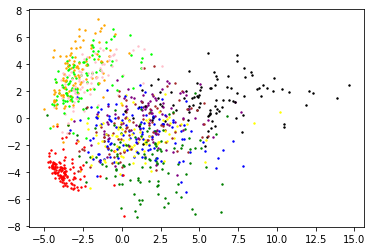

In [ ]:
#plt.scatter(low_dim_vectors[:,0], low_dim_vectors[:,1])
print(set(labels))
for i in range(int(low_dim_vectors.shape[0]/60)):# go thru and plot all points
  label = labels[i]
  x,y = low_dim_vectors[i]
  color = ""
  if label == 0:
    color = "black"
  elif label == 1:
    color = "red"
  elif label == 2:
    color = "green"  
  elif label == 3:
    color = "blue"  
  elif label == 4:
    color = "pink"
  elif label == 5:
    color = "purple"  
  elif label == 6:
      color = "yellow"
  elif label == 7:
      color = "orange"
  elif label == 8:
    color = "brown"
  else:
    color = "lime"           
  plt.scatter(x,y,c = color, s = 2)  

plt.show()